Configuraçao do Ambiente (ferramentas,base de dados,testes)

In [2]:
#Ferramentas utilizadas
import pandas as pd #leitura
import matplotlib.pyplot as plt #graficos
import ast #array em formato de string para formato de array normal
from geopy.geocoders import Nominatim #pegar coordenadas
import folium
from unidecode import unidecode
from IPython.display import display



In [3]:
#Bases de dados importadas
dados_ratings = pd.read_csv('desafio_ratings.csv',sep=';')
dados_details = pd.read_csv('desafio_details.csv',sep=';')

In [4]:
#Teste ratings
dados_ratings.head()

,Unnamed: 0,hotel_id,hotel_name,url,Comodidades,Limpeza,Conforto,Custo-benefício,Localização,Total,WiFi gratuito,number_of_ratings
0,2,10966118,Casa em lindo cond. a 5min da praia PEV105,https://www.booking.com/hotel/br/casa-em-lindo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,5,10959776,Apartamentos no Jardim Goiás Goiânia/GO - THO,https://www.booking.com/hotel/br/apartamentos-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,6,10949139,Casa triplex em condomínio Floripa-SC ALI024,https://www.booking.com/hotel/br/casa-triplex-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9,10948439,Apto com piscina no centro de Floripa PCE0406,https://www.booking.com/hotel/br/apto-com-pisc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,10,10943450,Apto espaçoso na beira do lago em Ilhéus ARS0169,https://www.booking.com/hotel/br/apto-espacoso...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
#Teste details
dados_details.head()

,Unnamed: 0,hotel_id,room_id,hotel_name,city_name,accommodation_type,room_name,room_surface_in_m2,room_facilities
0,0,10966441,1096644102,Apto belo e com churrasqueira na varanda VIC0203,Florianópolis,apartment,Apartamento,96.0,"['Taças de vinho', 'Secadora de roupas', 'Guar..."
1,1,10966258,1096625802,Chalés encantadores em Urubici/SC - PAR,Urubici,apartment,Bangalô,65.0,"['Banheiro privativo', 'Geladeira', 'TV', 'Sec..."
2,2,10966118,1096611801,Casa em lindo cond. a 5min da praia PEV105,Ubatuba,holiday_home,Casa de 3 Quartos,220.0,"['Taças de vinho', 'Cozinha', 'Vaso sanitário'..."
3,3,10961514,1096151402,Studio a 2min da UFSC Floripa-SC SSG0304,Florianópolis,apartment,Apartamento,51.0,"['Toalhas', 'Sofá-cama', 'Fogão', 'Chuveiro', ..."
4,4,10960702,1096070202,MGI - Apartamentos proximos da praia do Tororão,Arraial d'Ajuda,apartment,Villa Deluxe,130.0,"['Guarda-roupa ou armário', 'Área para refeiçõ..."


Análise 1 - Cidades em ordem crescente de número de listings (anúncio ou oferta de uma propriedade)

In [6]:
#Para isso vamos separar os valores de interesseas duplicações de um mesmo imovel (variados quartos possuem um unico anúncio) 
#e contar quantas vezes uma cidade aparece,o que resulta no número de imoveis por cidade
dados_listings = dados_details.loc[:,('hotel_id','city_name')].drop_duplicates()
dados_listings_ordenados = dados_listings['city_name'].value_counts(ascending=True).reset_index()
dados_listings_ordenados

,city_name,count
0,São José,1
1,Águas Brancas,1
2,Hidrolândia,1
3,Santa Cruz Cabrália,1
4,Taguatinga,1
5,Caldas Novas,1
6,Anitápolis,1
7,Camboriú,1
8,Praia do Rosa,1
9,Pirenópolis,1


Análise 2- Cidades em ordem decrescente de metros quadrados

In [7]:
#Para isso separar os dados em interesse e depois vamos agrupa-los em cidades e somar todos os m2 por meio da funcao 'sum()'
dados_m2 = dados_details.loc[:,('city_name','room_surface_in_m2')]
dados_m2_soma = dados_m2.groupby('city_name').sum().sort_values(by='room_surface_in_m2',ascending=False).reset_index()
dados_m2_soma

,city_name,room_surface_in_m2
0,Florianópolis,49473.22
1,Goiânia,5342.00
2,Bombinhas,4247.00
3,Balneário Camboriú,4023.80
4,Itapema,2553.80
5,Campos do Jordão,2495.00
6,Porto Seguro,2019.26
7,Cabo Frio,1687.00
8,Ubatuba,1476.00
9,Itajaí,1368.37


Análise 3 - Quais cidades têm mais avaliações?

In [8]:
#Para isso vamos usar 2 dados em tabelas distintas já que eles estão separados em 2 bancos de dados diferentes
#Vamos usar da desafio_ratings = hotel_id,number_of_ratings e da desafio_details = hotel_id,city_name
#e concilia-lás para termos um dataFrame que junte as cidades aos números de avaliação

dados_hotel_cidade = dados_details.loc[:,('hotel_id','city_name')].drop_duplicates()
dados_hotel_cidade

,hotel_id,city_name
0,10966441,Florianópolis
1,10966258,Urubici
2,10966118,Ubatuba
3,10961514,Florianópolis
4,10960702,Arraial d'Ajuda
...,...,...
1153,4584108,Florianópolis
1191,4549889,Florianópolis
1245,4504984,Florianópolis
1304,2966211,Florianópolis


In [9]:
dados_hotel_ratings = dados_ratings.loc[:,('hotel_id','number_of_ratings')]
dados_hotel_ratings

,hotel_id,number_of_ratings
0,10966118,0
1,10959776,0
2,10949139,0
3,10948439,0
4,10943450,0
...,...,...
708,4584108,633
709,4549889,305
710,4504984,446
711,2966211,29


In [10]:
#Agora juntando as 2 com a função 'pd.merge()' com base no hotel_id e após isso agrupar por cidade e somar tudo pela função 'sum()'
dados_hotel_cidade_ratings = pd.merge(dados_hotel_cidade,dados_hotel_ratings,on='hotel_id')
dados_num_avaliacao = dados_hotel_cidade_ratings.loc[:,('city_name','number_of_ratings')].groupby('city_name').sum().sort_values(by='number_of_ratings',ascending=False)
dados_num_avaliacao

,number_of_ratings
city_name,
Florianópolis,3264
Campos do Jordão,135
Bombinhas,128
Anitápolis,78
Balneário Camboriú,54
Itajaí,23
Itapema,19
Goiânia,19
Gramado,15


Análise 4 - Quais cidades têm a maior média de avaliações? E a menor média?

In [11]:
#Utiliza os dados encontrados anteriomente 'dados_hotel_cidade_ratings',agrupa-os novamente por cidade
#e em vez de somar tudo,calcula-se a media por meio da funcao 'mean()'
dados_media_avaliacao = dados_hotel_cidade_ratings.loc[:,('city_name','number_of_ratings')].groupby('city_name').mean().sort_values(by='number_of_ratings',ascending=False)
dados_media_avaliacao

,number_of_ratings
city_name,
Anitápolis,78.000000
Campos do Jordão,13.500000
Florianópolis,7.789976
São José,6.000000
Bombinhas,4.413793
Petrópolis,4.000000
Itajaí,2.300000
Balneário Camboriú,1.542857
Gramado,1.071429


Análise 5 - Existem correlações entre as características de um anúncio e a sua localização?

In [12]:
#Para essa vou verificar essa correlaçao vou analisar uma caracteristica que define demais a experiencia do cliente : tipo de locação

In [13]:
dados_tipo = dados_details.loc[:,('hotel_id','city_name','accommodation_type')].drop_duplicates()
dados_por_tipo = dados_tipo.loc[:,('city_name','accommodation_type')].value_counts().reset_index()
dados_por_tipo

,city_name,accommodation_type,count
0,Florianópolis,apartment,348
1,Florianópolis,holiday_home,56
2,Balneário Camboriú,apartment,35
3,Goiânia,apartment,29
4,Itapema,apartment,21
...,...,...,...
63,Anitápolis,chalet,1
64,Hidrolândia,farm_holiday,1
65,Imbituba,lodge,1
66,Imbituba,inn,1


In [14]:
# Supondo que seus dados estejam em um DataFrame chamado df
# Substitua df pelo nome real do seu DataFrame

# Crie um DataFrame com as colunas 'city_name', 'accommodation_type' e 'count'
dados_por_tipo = dados_por_tipo[['city_name', 'accommodation_type', 'count']].drop_duplicates()

# Crie uma tabela dinâmica para obter a contagem total por tipo de acomodação e cidade
accommodation_counts = pd.pivot_table(dados_por_tipo, values='count', index='city_name', columns='accommodation_type', fill_value=0)

# Adicione uma coluna indicando se há mais apartamentos do que a soma das outras locações
accommodation_counts['more_apartments_than_others'] = accommodation_counts['apartment'] > accommodation_counts.drop('apartment', axis=1).sum(axis=1)

# Exiba o resultado
accommodation_counts.reset_index(inplace=True)


In [15]:
#configurar o geolocalizador sem verificação SSL
geolocator = Nominatim(user_agent="my_geocoder", ssl_context=None)

#função para mapear a nota para uma cor
def map_nota_to_color(tipo):
    # Usei um gradiente de azul para verde para vermelho
    if not tipo:
        return 'blue'
    else:
        return 'red'

#função para manipular o nome da cidade
def format_city_name(city):

    #remover acentos e converter para minúsculas e adicionando brasil para diminuir erros relativos a localização
    formatted_city = unidecode(city).lower()+ '-brasil'

    #cidades que não condiziam com a localização encontrada e precisaram de uma ajuda na pesquisa
    if formatted_city == 'brasilia-brasil':
        formatted_city = 'brasilia-df-brasil'
    if formatted_city == 'sao jose-brasil':
        formatted_city = 'sao jose-sc-brasil'

    return formatted_city

#criar um mapa básico centrado em uma localização do brasil
mapa = folium.Map(location=[-15.7801, -47.9292], zoom_start=4)

#adicionar marcadores ao mapa
for index, row in accommodation_counts.iterrows():
    #manipular o nome da cidade antes de fazer a pesquisa
    formatted_city_name = format_city_name(row['city_name'])
    
    #obter as coordenadas a partir do nome da cidade
    location = geolocator.geocode(formatted_city_name, timeout=10)

    #verificar se a localização foi encontrada
    if location:
        #mapear a nota para a cor do ícone
        color = map_nota_to_color(row['more_apartments_than_others'])

        #criar marcador com popup contendo informações e cor ajustada
        folium.Marker(
            location=[location.latitude, location.longitude],
            popup=f"{row['city_name']}",
            icon=folium.Icon(color=color, icon='home')
        ).add_to(mapa)

#exibir o mapa no notebook
display(mapa)

Análise 6 - Existem relações entre a nota do anúncio e os recursos disponíveis no imóvel?

In [16]:
#Para esse vamos precisar fazer a média de todos os recursos de cada imóvel (já que cada quarto possui recursos diferentes) 
#e com a média de recursos de cada imóvel calcula a relação deles com a nota

def calcular_tamanho(lista_string):
    lista = ast.literal_eval(lista_string)
    return len(lista)

numeros_de_recursos = dados_details.loc[:,('hotel_id','room_facilities')]
numeros_de_recursos['num_of_facilities'] = numeros_de_recursos['room_facilities'].apply(calcular_tamanho)
numeros_de_recursos_media = numeros_de_recursos.loc[:,('hotel_id','num_of_facilities')].groupby('hotel_id').mean().reset_index()

In [17]:
#Agora ligar o hotel_id e a nota (apenas hoteis que possuem alguma avaliação)

dados_hotel_nota= dados_ratings.loc[:,('hotel_id','Total')]
dados_hotel_nota.dropna(inplace=True)
dados_hotel_nota

,hotel_id,Total
61,10812173,10.0
78,10792136,10.0
83,10790322,10.0
86,10779085,10.0
89,10778804,10.0
...,...,...
708,4584108,9.2
709,4549889,9.2
710,4504984,9.1
711,2966211,7.7


In [18]:
#Agora por fim,juntar os 2 dados e calcular sua correlação

dados_recursos_nota = pd.merge(dados_hotel_nota,numeros_de_recursos_media,on='hotel_id')
correlacao = dados_recursos_nota.loc[:,('Total', 'num_of_facilities')].corr()
print(correlacao) #0.146964 = fraca

                      Total  num_of_facilities
Total              1.000000           0.121698
num_of_facilities  0.121698           1.000000


/var/folders/2z/6hvf6bz12gndgkd909_4hvdr0000gn/T/ipykernel_979/1717063519.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_recursos_por_faixa = dados_recursos_nota.groupby('faixa_notas')['num_of_facilities'].mean()


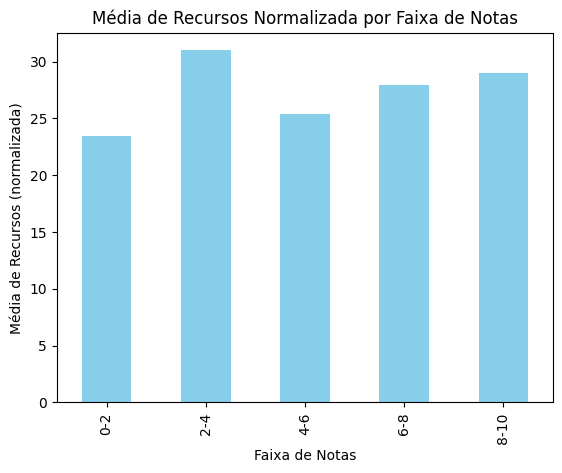

In [19]:
#vamos tentar observar isso de uma maneira mais visual, dividindo os hotel_id pela nota no caso(0-2,2-4,4-6,8-10) e usando a media de recursos como paramentro
#o que nos leva a uma observação mais clara que essa correlação é fraca de maneira mais visual

#definir as faixas de notas
faixas_notas = [0, 2, 4, 6, 8, 10]

#criar uma coluna 'faixa_notas' no DataFrame
dados_recursos_nota['faixa_notas'] = pd.cut(dados_recursos_nota['Total'], bins=faixas_notas, labels=[f'{i}-{i+2}' for i in range(0, 10, 2)])

#calcular a média de recursos para cada faixa de notas
media_recursos_por_faixa = dados_recursos_nota.groupby('faixa_notas')['num_of_facilities'].mean()

#plotar o gráfico de barras
media_recursos_por_faixa.plot(kind='bar', color='skyblue')
plt.title('Média de Recursos Normalizada por Faixa de Notas')
plt.xlabel('Faixa de Notas')
plt.ylabel('Média de Recursos (normalizada)')
plt.show()

In [20]:
#E agora testando com recursos especificos('Ar-condicionado')
def tem_recurso(lista_string):
    lista = ast.literal_eval(lista_string)
    if 'Ar-condicionado'in lista:
        return True
    else:
        return False
    
dados_tem_ar = dados_details.loc[:,('hotel_id','room_facilities')]
dados_tem_ar['tem_ar'] = dados_tem_ar['room_facilities'].apply(tem_recurso)
dados_tem_ar_media = dados_tem_ar.loc[:,('hotel_id','tem_ar')]
dados_tem_ar_media.drop_duplicates(inplace=True)

dados_hotel_nota.dropna(inplace=True)
dados_ar_nota = pd.merge(dados_tem_ar_media,dados_hotel_nota,on='hotel_id')
dados_ar_nota.loc[:,('tem_ar','Total')].groupby('tem_ar').mean()

,Total
tem_ar,
False,8.375000
True,8.459779


In [21]:
#E agora testando com recursos especificos(Vista do mar)
def tem_recurso(lista_string):
    lista = ast.literal_eval(lista_string)
    if 'Vista do mar'in lista:
        return True
    else:
        return False
    
dados_tem_vista = dados_details.loc[:,('hotel_id','room_facilities')]
dados_tem_vista['tem_vista'] = dados_tem_vista['room_facilities'].apply(tem_recurso)
dados_tem_vista_media = dados_tem_vista.loc[:,('hotel_id','tem_vista')]
dados_tem_vista_media.drop_duplicates(inplace=True)

dados_hotel_nota.dropna(inplace=True)
dados_vista_nota = pd.merge(dados_tem_vista_media,dados_hotel_nota,on='hotel_id')
dados_vista_nota.loc[:,('tem_vista','Total')].groupby('tem_vista').mean()

,Total
tem_vista,
False,8.474419
True,8.218750


Análise 7 - Existe alguma relação entre a nota recebida e a localização?

In [22]:
#Para vizualizaçao disso vamos fazer a media de nota de cada cidade e depois disso plotar um mapa

dados_hotel_nota = dados_ratings.loc[:,('hotel_id','Total')]
dados_nota_cidade = pd.merge(dados_hotel_nota,dados_hotel_cidade,on='hotel_id')
dados_nota_media_por_cidade = dados_nota_cidade.loc[:,('city_name','Total')].groupby('city_name').mean().reset_index()
dados_nota_media_por_cidade.dropna(inplace=True)
dados_nota_media_por_cidade


,city_name,Total
0,Angra dos Reis,10.000000
1,Anitápolis,9.400000
3,Balneário Camboriú,8.150000
5,Bombinhas,8.863636
6,Brasília,10.000000
8,Cabo Frio,9.500000
10,Camboriú,1.000000
11,Campos do Jordão,8.700000
12,Canela,9.000000
13,Florianópolis,8.373430


In [23]:
#configurar o geolocalizador sem verificação SSL
geolocator = Nominatim(user_agent="my_geocoder", ssl_context=None)

#função para mapear a nota para uma cor
def map_nota_to_color(nota):
    if 0 <= nota < 3:
        return 'red'
    elif 3 <= nota < 7:
        return 'orange'
    elif 7 <= nota < 9:
        return 'green'
    else:
        return 'purple'

#criar um mapa básico centrado em uma localização do brasil
mapa = folium.Map(location=[-15.7801, -47.9292], zoom_start=4)

#adicionar marcadores ao mapa
for index, row in dados_nota_media_por_cidade.iterrows():
    #manipular o nome da cidade antes de fazer a pesquisa
    formatted_city_name = format_city_name(row['city_name'])
    
    #obter as coordenadas a partir do nome da cidade
    location = geolocator.geocode(formatted_city_name, timeout=10)

    #verificar se a localização foi encontrada
    if location:
        # Mapear a nota para a cor do ícone
        color = map_nota_to_color(row['Total'])

        #criar marcador com popup contendo informações e cor ajustada
        folium.Marker(
            location=[location.latitude, location.longitude],
            popup=f"{row['city_name']}: {row['Total']}",
            icon=folium.Icon(color=color, icon='home')
        ).add_to(mapa)

#exibir o mapa no notebook
display(mapa)

Análise 8 - Conclusão sobre as notas dos imóveis

- De acordo com as analises anteriores podemos inferir:

- Imovéis localizados em cidades que possuem praia costumam fazer mais sucesso entre os demais.

- A quantidade de recursos disponiveis não necessariamente impacta sobre a nota,o que impacta de verdade é a qualidade e experiencia que o cliente vivenciouao utilizar algum desses recursos. 

- Imovéis localizados em cidades que possuem praia costumam fazer mais sucesso entre os demais. 

- A localização do imóvel importa muito na sua avaliação, já que também faz parte da experiencia do cliente.

Análise 9 - Anúncios críticos

- Todos os anúncios sem avaliação : anúncios sem avaliação deixam o cliente com um certo receio de ir para aquele local, já que ele não possui nenhuma referência daquele hotel.

- Anúncios com poucas avaliações e notas abaixo de 7: ainda com o mesmo motivo da passada, só que em uma situação mais complicada, porque além de possuir poucas opiniões, eles ainda são negativas,o que causa total receio por parte do cliente. 
